In [1]:
%matplotlib inline
import os
import sys
import json
import spotipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.client import SpotifyException

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier

from spotirecs import get_playlist_tracks, get_features, Playlists
from spotirecs.plotting import plot_features

# pandas settings
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_columns', 0)
pd.set_option('display.expand_frame_repr', False)

In [2]:
def dict_to_json(data: dict, path: str):
    with open(path, "w", encoding="utf-8") as outfile:
        json.dump(data, outfile)

In [3]:
username_id = '113586775'

playlist_of_interest_name = 'Favorites'

## Initialization

In [4]:
# Logging in

spotify = spotipy.Spotify(requests_timeout=10, client_credentials_manager=SpotifyClientCredentials())

# Which playlists do I have?
playlists: Playlists | None = spotify.user_playlists(username_id)
if playlists is None:
    print("Playlists could not be retrieved")
    sys.exit(1)

playlist_of_interest = None

playlists_of_no_interest = []
for playlist in playlists['items']:
    if playlist['name'] == playlist_of_interest_name:
        playlist_of_interest = playlist
    elif playlist['owner']['id'] == username_id:
        playlists_of_no_interest.append(playlist)


In [5]:
if playlist_of_interest is None:
    print("Given playlist name can not be found")
    sys.exit(1)

good_track_ids, good_track_names = get_playlist_tracks(spotify, playlist_of_interest)

bad_track_ids = []
bad_track_names = []

for playlist in playlists_of_no_interest:
    tmp_ids, tmp_names = get_playlist_tracks(spotify, playlist)
    
    for tmp_id, tmp_name in zip(tmp_ids, tmp_names):
        if tmp_id not in good_track_ids and tmp_id not in bad_track_ids:
            bad_track_ids.append(tmp_id)
            bad_track_names.append(tmp_name)

In [6]:
ratings = [1] * len(good_track_ids) + [0] * len(bad_track_ids)
track_ids = good_track_ids + bad_track_ids
track_names = good_track_names + bad_track_names

## Feature-extraction

In [7]:
data_file = "track_features.csv"

features = get_features(spotify, track_ids)
favorites_df = pd.DataFrame(features, index=track_names)
favorites_df['rating'] = ratings

In [8]:
if os.path.isfile(data_file):
    # If the data file exists, look for new tracks and append their features
    print("Audio features found")
    read_df = pd.read_csv(data_file, index_col=0)
    read_ids = read_df['id']
    
    print("\tFinding new tracks ...")
    tmp_indices = []
    for i, track_id in enumerate(track_ids):
        if track_id not in read_ids.values:
            tmp_indices.append(i)

    new_ids = [track_ids[i] for i in tmp_indices]
    new_names = [track_names[i] for i in tmp_indices]
    new_ratings = [ratings[i] for i in tmp_indices]

    new_features = get_features(spotify, new_ids)
    new_features_df = pd.DataFrame(new_features, index=new_names)
    new_features_df['rating'] = new_ratings
    
    if new_features_df.size > 0:
        print("\tAppending new track features to main file ...")
        new_features_df.to_csv(data_file, mode='a')

        print("\tCreating audio features dataframe ...")
        read_df = pd.concat([read_df, new_features_df])
        favorites_df = read_df[read_df['id'].isin(track_ids)]

favorites_df.to_csv(data_file)

print("Done!")
favorites_df

Audio features found
	Finding new tracks ...
Done!


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,rating
Citizen/Soldier,0.631,0.822,8,-5.503,1,0.0343,0.01140,0.017000,0.1970,0.4830,96.999,audio_features,3NZr9rsioE182Rv8dqZG6g,spotify:track:3NZr9rsioE18...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,232907,4,1
Waterline - 2010 - Remaster,0.386,0.797,0,-7.230,1,0.0372,0.00189,0.000005,0.0959,0.2300,108.836,audio_features,0ayPGGN1YW9lU7v00uOM5E,spotify:track:0ayPGGN1YW9l...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,273160,4,1
Love Is a Loser's Game - 2010 - Remaster,0.307,0.555,10,-7.354,0,0.0255,0.01410,0.000000,0.0865,0.2650,90.640,audio_features,7oyVUb08xXoOqlvtoI1c8Y,spotify:track:7oyVUb08xXoO...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,227933,4,1
Sweet Child O' Mine,0.435,0.947,6,-4.759,1,0.0489,0.08760,0.072700,0.1130,0.6370,125.133,audio_features,32e5Wq10DT7xYrlRl5qSYF,spotify:track:32e5Wq10DT7x...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,355267,4,1
Paradise City,0.277,0.979,11,-5.578,1,0.0979,0.01830,0.013800,0.1170,0.4510,100.339,audio_features,2bHQrsgmBzX5WF7thpMZrV,spotify:track:2bHQrsgmBzX5...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,406200,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Riddles In The Dark,0.172,0.228,2,-17.281,0,0.0397,0.62200,0.945000,0.0705,0.0339,129.148,audio_features,2V3hP9u4jI9I9ftHrgZ0MF,spotify:track:2V3hP9u4jI9I...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,320467,3,0
Brass Buttons,0.161,0.345,9,-16.228,0,0.0435,0.13100,0.853000,0.1890,0.0603,94.033,audio_features,5kHSrLEGsoOTfazEKvVliP,spotify:track:5kHSrLEGsoOT...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,457107,4,0
Out Of The Frying-Pan,0.358,0.536,9,-12.392,1,0.0372,0.18100,0.904000,0.1930,0.1990,89.793,audio_features,608UmlS8Q8Kp3EztDD2SUI,spotify:track:608UmlS8Q8Kp...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,353440,4,0
A Good Omen,0.173,0.388,0,-15.277,1,0.0366,0.03810,0.909000,0.1710,0.0491,112.089,audio_features,2wcmpZsg0O4R0xNeUPZ50o,spotify:track:2wcmpZsg0O4R...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,344747,4,0


## Pre-processing

In [9]:
training_df = favorites_df[["acousticness", "danceability", "duration_ms", "energy", "instrumentalness",  "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence", "rating"]]
training_df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,rating
Citizen/Soldier,0.01140,0.631,232907,0.822,0.017000,8,0.1970,-5.503,1,0.0343,96.999,0.4830,1
Waterline - 2010 - Remaster,0.00189,0.386,273160,0.797,0.000005,0,0.0959,-7.230,1,0.0372,108.836,0.2300,1
Love Is a Loser's Game - 2010 - Remaster,0.01410,0.307,227933,0.555,0.000000,10,0.0865,-7.354,0,0.0255,90.640,0.2650,1
Sweet Child O' Mine,0.08760,0.435,355267,0.947,0.072700,6,0.1130,-4.759,1,0.0489,125.133,0.6370,1
Paradise City,0.01830,0.277,406200,0.979,0.013800,11,0.1170,-5.578,1,0.0979,100.339,0.4510,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Riddles In The Dark,0.62200,0.172,320467,0.228,0.945000,2,0.0705,-17.281,0,0.0397,129.148,0.0339,0
Brass Buttons,0.13100,0.161,457107,0.345,0.853000,9,0.1890,-16.228,0,0.0435,94.033,0.0603,0
Out Of The Frying-Pan,0.18100,0.358,353440,0.536,0.904000,9,0.1930,-12.392,1,0.0372,89.793,0.1990,0
A Good Omen,0.03810,0.173,344747,0.388,0.909000,0,0.1710,-15.277,1,0.0366,112.089,0.0491,0


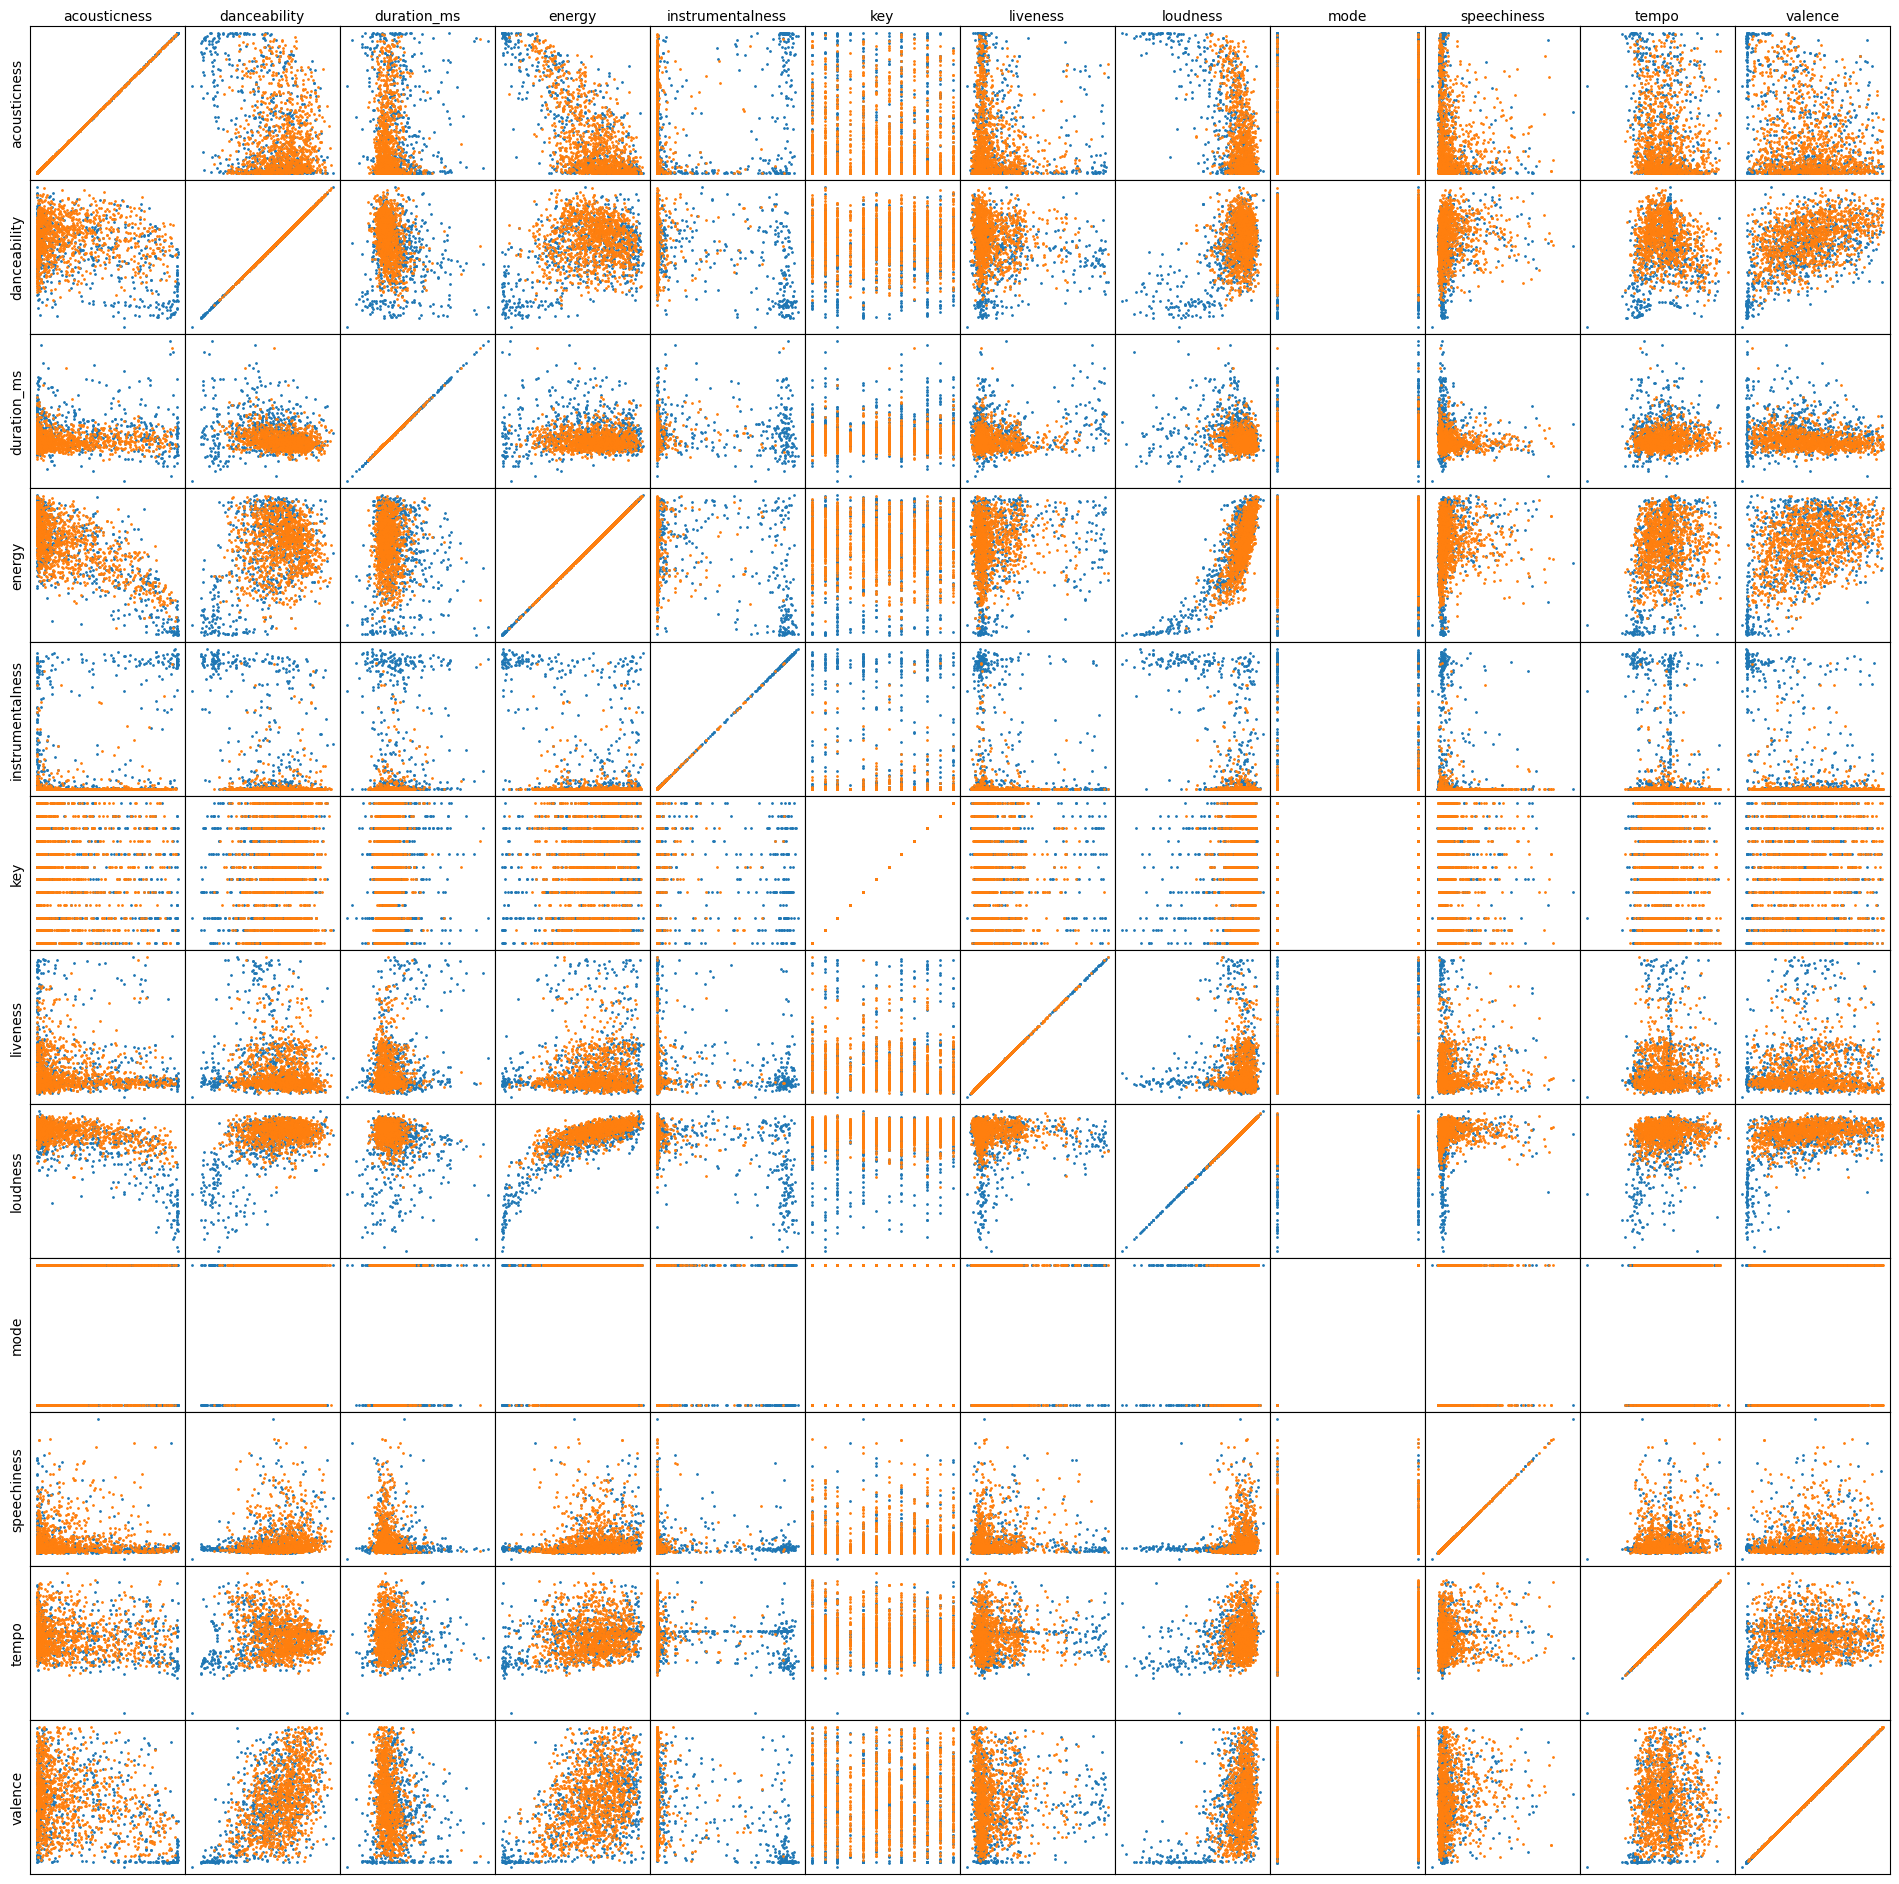

In [10]:
column_names = training_df.columns[:-1]

ratings = training_df['rating'].to_numpy()
training_array = training_df.to_numpy()

fig, _ = plot_features(column_names, training_array[ratings == 0], training_array[ratings == 1])

Number of components for 95% variance: 10


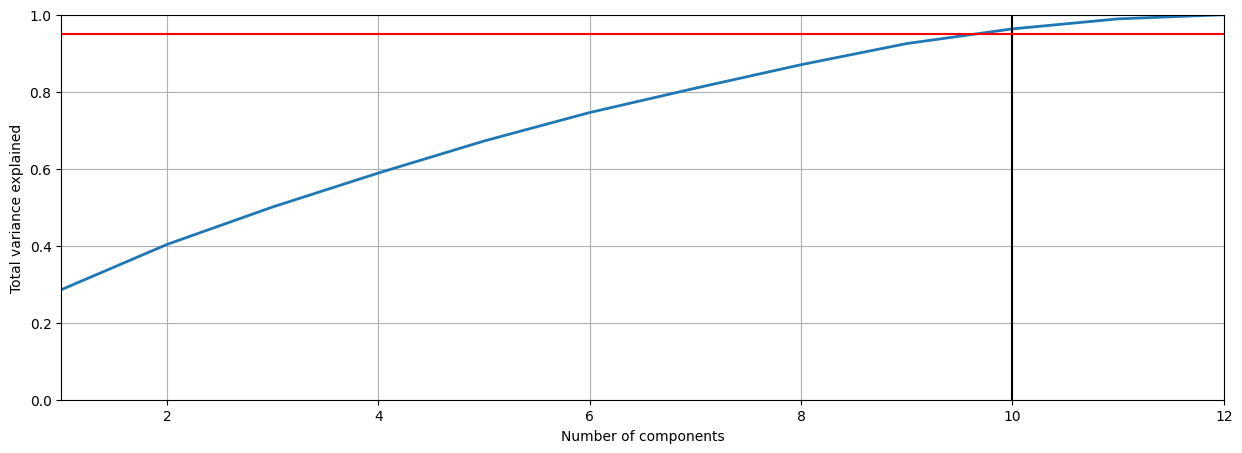

In [11]:
X_train = training_df.drop('rating', axis=1)
y_train = training_df['rating']

X_scaled = StandardScaler().fit_transform(X_train)
pca = decomposition.PCA().fit(X_scaled)

variance_ratio = pca.explained_variance_ratio_
cum_var = np.cumsum(variance_ratio)
threshold = 0.95
n_components = next(i for i, v in enumerate(cum_var) if v > threshold) + 1
print(f"Number of components for {threshold*100:.0f}% variance: {n_components}")

plt.figure(figsize=(15,5))
plt.plot(range(1,13), cum_var, lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total variance explained')
plt.xlim(1, 12)
plt.ylim(0, 1)
plt.grid()
plt.axvline(n_components, c='k')
plt.axhline(threshold, c='r')


(<Figure size 2000x2000 with 100 Axes>,
 array([[<Axes: xlabel='Component #1', ylabel='Component #1'>,
         <Axes: xlabel='Component #2'>, <Axes: xlabel='Component #3'>,
         <Axes: xlabel='Component #4'>, <Axes: xlabel='Component #5'>,
         <Axes: xlabel='Component #6'>, <Axes: xlabel='Component #7'>,
         <Axes: xlabel='Component #8'>, <Axes: xlabel='Component #9'>,
         <Axes: xlabel='Component #10'>],
        [<Axes: ylabel='Component #2'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='Component #3'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='Component #4'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='Component #5'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<A

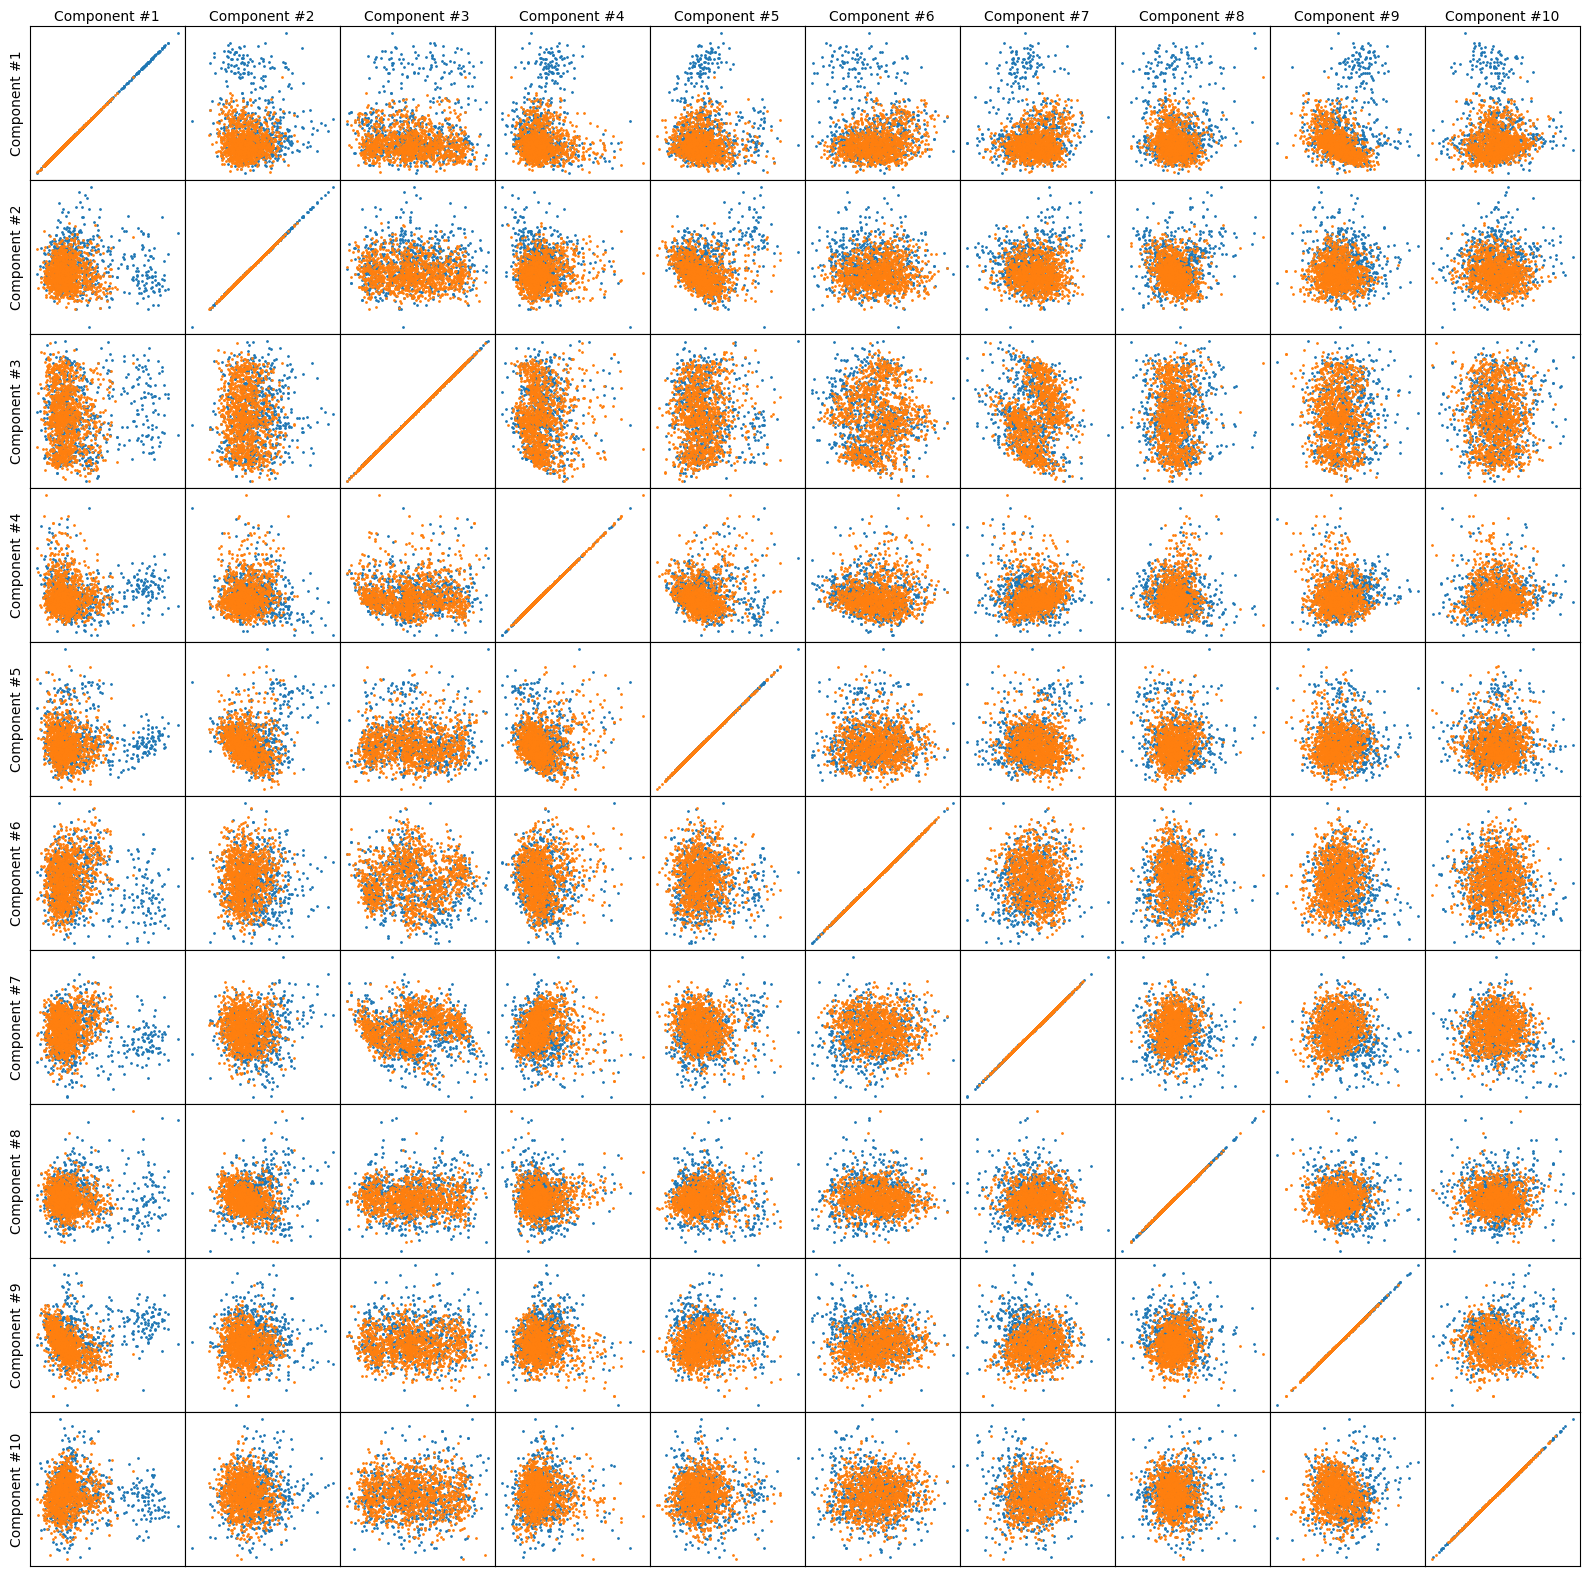

In [12]:
# Fit your dataset to the optimal pca
pca = decomposition.PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_scaled)

column_names = [f"Component #{i + 1}" for i in range(n_components)]
plot_features(column_names, X_train_pca[y_train == 0], X_train_pca[y_train == 1])

In [13]:
v = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 6), max_features=10000)
X_names_sparse = v.fit_transform(track_names)
X_names_sparse.shape

X_train = sparse.csr_matrix(sparse.hstack([X_train_pca, X_names_sparse]))
X_train.shape

(1937, 10010)

## Training

In [14]:
# K-nearest neighbor classification
n_splits = 5
max_neighbors = 50

skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

knc_params = {'n_neighbors': range(1, max_neighbors + 1)}
knc = KNeighborsClassifier(n_jobs=-1)

knc_grid = GridSearchCV(knc, knc_params, n_jobs=-1, cv=skf, verbose=1)
knc_grid.fit(X_train, y_train)
print("Best score: ", knc_grid.best_score_)

grid_results = pd.DataFrame(knc_grid.cv_results_)
grid_results

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score:  0.7346532939076694


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004399,0.001552,1.044956,0.407208,1,{'n_neighbors': 1},0.688144,0.649485,0.656331,0.648579,0.682171,0.664942,0.016829,49
1,0.005579,0.003587,0.861611,0.181743,2,{'n_neighbors': 2},0.680412,0.608247,0.627907,0.643411,0.638243,0.639644,0.023672,50
2,0.004034,0.002964,0.816539,0.092624,3,{'n_neighbors': 3},0.729381,0.675258,0.689922,0.692506,0.715762,0.700566,0.019391,47
3,0.003980,0.001173,0.720192,0.072175,4,{'n_neighbors': 4},0.716495,0.646907,0.651163,0.695090,0.656331,0.673197,0.027623,48
4,0.002831,0.000661,0.681417,0.080553,5,{'n_neighbors': 5},0.755155,0.682990,0.692506,0.728682,0.723514,0.716569,0.026040,44
5,0.003259,0.001254,0.766249,0.112834,6,{'n_neighbors': 6},0.742268,0.667526,0.692506,0.731266,0.715762,0.709866,0.026969,46
6,0.005377,0.003512,0.825442,0.161133,7,{'n_neighbors': 7},0.747423,0.685567,0.705426,0.726098,0.741602,0.721223,0.023006,42
7,0.003255,0.001263,0.691756,0.063631,8,{'n_neighbors': 8},0.755155,0.675258,0.697674,0.713178,0.713178,0.710889,0.026131,45
8,0.002780,0.000719,0.658922,0.038478,9,{'n_neighbors': 9},0.750000,0.690722,0.720930,0.715762,0.739018,0.723286,0.020414,39
9,0.002835,0.000694,0.688445,0.059155,10,{'n_neighbors': 10},0.755155,0.685567,0.723514,0.702842,0.720930,0.717602,0.023239,43


(0.0, 50.0)

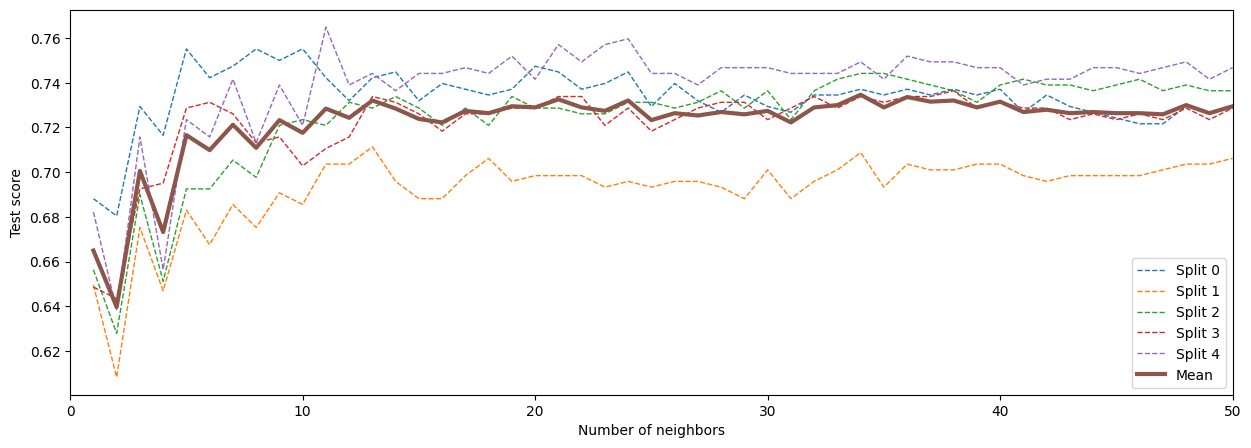

In [15]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results['param_n_neighbors'], grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['param_n_neighbors'], grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Test score')
plt.xlim(0, max_neighbors)

In [16]:
# Random Forest classification

rfc_parameters = {
    'max_features': [4, 6, 8, 10], 
    'min_samples_leaf': [1, 3, 5, 7],
    'max_depth': [3, 5, 7]
}
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
forest_grid = GridSearchCV(rfc, rfc_parameters, n_jobs=-1, cv=skf, verbose=1)
forest_grid.fit(X_train, y_train)
print("Best score: ", forest_grid.best_score_)

grid_results = pd.DataFrame(forest_grid.cv_results_)
grid_results

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score:  0.6257105943152454


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.618200,0.046534,0.076422,0.046736,3,4,1,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
1,0.674309,0.124450,0.113609,0.084586,3,4,3,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
2,0.727232,0.158638,0.049592,0.007503,3,4,5,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
3,0.590073,0.032577,0.047155,0.008030,3,4,7,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
4,0.576064,0.025010,0.050978,0.006643,3,6,1,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
5,0.543022,0.032260,0.044710,0.005564,3,6,3,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
6,0.560386,0.016475,0.046051,0.004238,3,6,5,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
7,0.576368,0.026786,0.046622,0.008671,3,6,7,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
8,0.578757,0.017597,0.044977,0.004359,3,8,1,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8
9,0.538899,0.010463,0.050511,0.006890,3,8,3,"{'max_depth': 3, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,8


([], [])

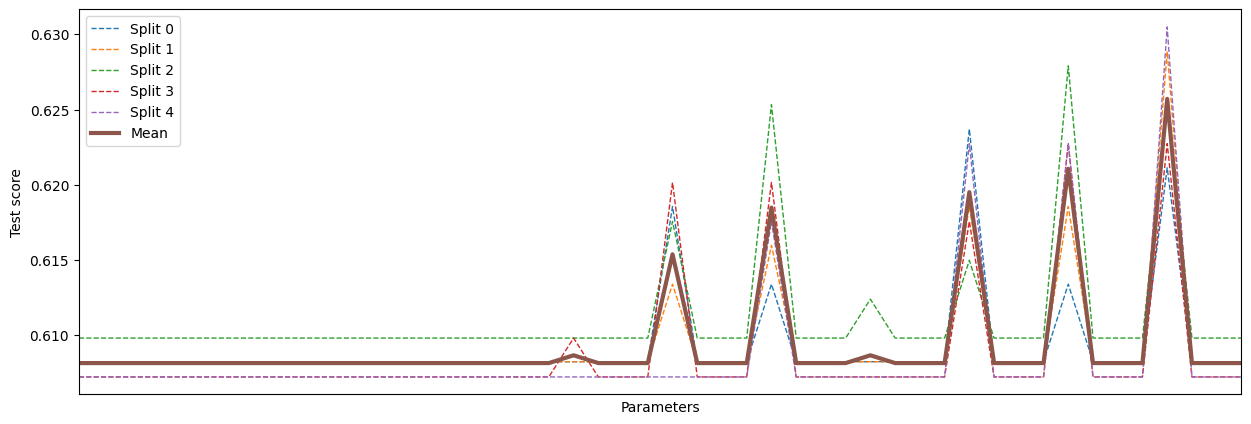

In [17]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Parameters')
plt.ylabel('Test score')
plt.xlim(0, len(grid_results.index) - 1)
plt.xticks([])

In [18]:
# Decision tree classification

tree_parameters = {
    'max_depth': range(1,11),
    'max_features': range(4, 11)
}
tree = DecisionTreeClassifier()
tree_grid = GridSearchCV(tree, tree_parameters, cv=skf, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)
print("Best score: ", tree_grid.best_score_)

grid_results = pd.DataFrame(tree_grid.cv_results_)
grid_results

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Best score:  0.6287860624950052


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006355,0.001642,0.005012,0.003292,1,4,"{'max_depth': 1, 'max_feat...",0.613402,0.608247,0.609819,0.607235,0.607235,0.609188,0.002309,62
1,0.005220,0.000881,0.002411,0.000697,1,5,"{'max_depth': 1, 'max_feat...",0.608247,0.608247,0.609819,0.609819,0.607235,0.608674,0.001006,64
2,0.006064,0.001703,0.002039,0.000220,1,6,"{'max_depth': 1, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.612403,0.609190,0.001807,59
3,0.005806,0.002889,0.002367,0.000584,1,7,"{'max_depth': 1, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,66
4,0.004403,0.000647,0.002834,0.000811,1,8,"{'max_depth': 1, 'max_feat...",0.608247,0.608247,0.609819,0.607235,0.607235,0.608157,0.000946,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.005950,0.000673,0.002964,0.001037,10,6,"{'max_depth': 10, 'max_fea...",0.621134,0.634021,0.627907,0.612403,0.614987,0.622090,0.008017,4
66,0.005631,0.001030,0.003048,0.001096,10,7,"{'max_depth': 10, 'max_fea...",0.608247,0.610825,0.609819,0.612403,0.622739,0.612807,0.005147,34
67,0.007597,0.002576,0.002089,0.000197,10,8,"{'max_depth': 10, 'max_fea...",0.618557,0.626289,0.609819,0.607235,0.609819,0.614344,0.007098,25
68,0.006518,0.001415,0.002822,0.001012,10,9,"{'max_depth': 10, 'max_fea...",0.641753,0.657216,0.625323,0.607235,0.612403,0.628786,0.018554,1


([], [])

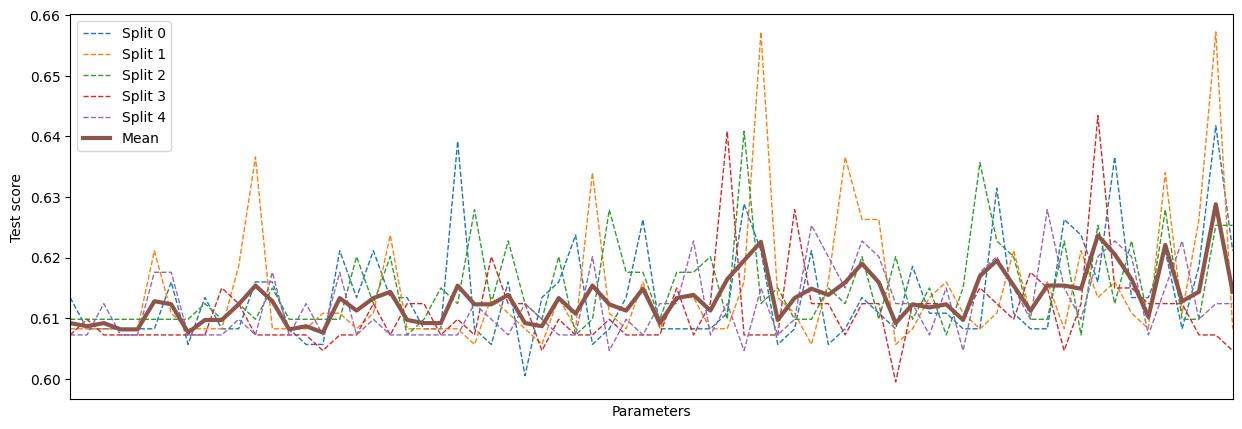

In [19]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Parameters')
plt.ylabel('Test score')
plt.xlim(0, len(grid_results.index) - 1)
plt.xticks([])

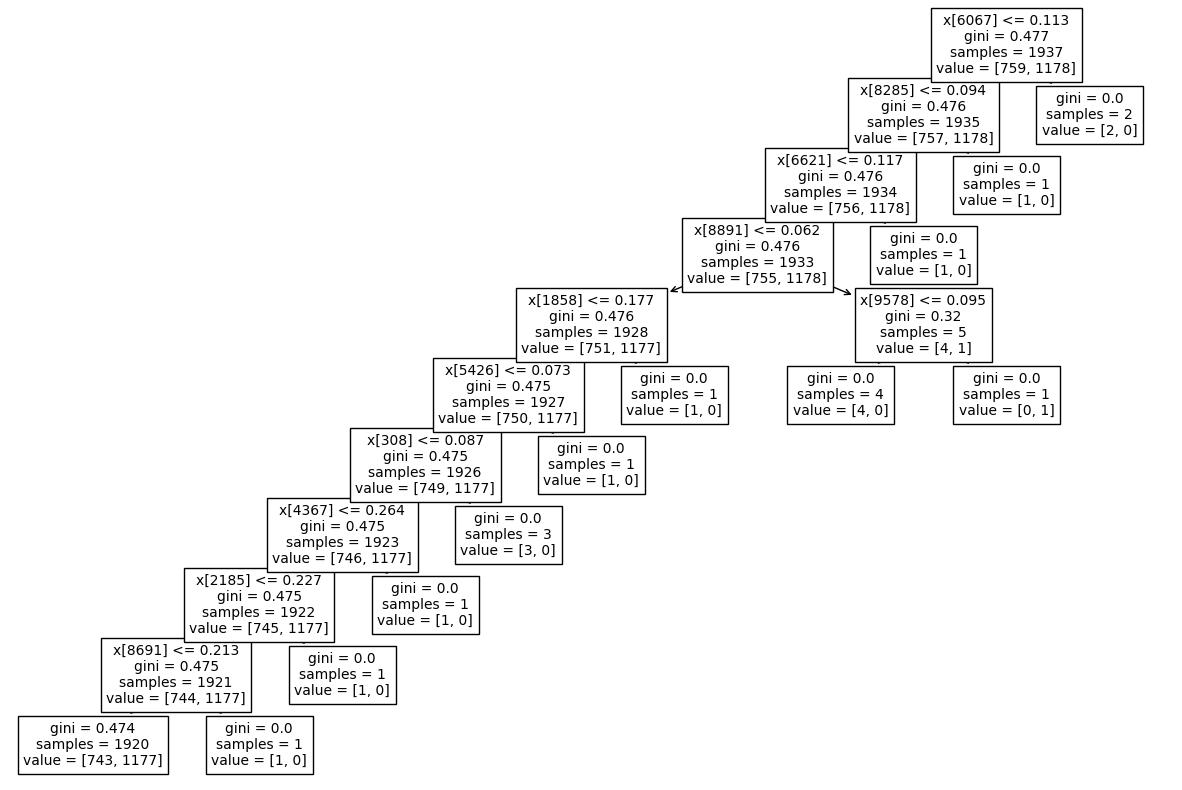

In [20]:
plt.figure(figsize=(15, 10))
plot_tree(tree_grid.best_estimator_, fontsize=10)
print()

## Testing

In [21]:
rec_tracks_per_track = 1
max_training_size = 50

rec_tracks = []
for i in favorites_df['id']:
    try:
        rec_tracks.extend(spotify.recommendations(seed_tracks=[i], limit=rec_tracks_per_track)['tracks'])
    except:
        break

    if len(rec_tracks) >= max_training_size:
        rec_tracks = rec_tracks[:max_training_size]
        break


In [22]:
rec_track_ids = []
rec_track_names = []
for i in rec_tracks:
    rec_track_ids.append(i['id'])
    rec_track_names.append(i['name'])

rec_features = get_features(spotify, rec_track_ids)
        
rec_playlist_df = pd.DataFrame(rec_features, index=rec_track_names)
rec_playlist_df.drop_duplicates(subset='id', inplace=True)
rec_track_names = rec_playlist_df.index.tolist()
rec_playlist_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
Move Your Body,0.626,0.8970,11,-3.650,1,0.0514,0.000502,0.000000,0.3330,0.883,121.986,audio_features,29JkmIEHcUg0R4BQ8o4PmJ,spotify:track:29JkmIEHcUg0...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,193107,4
Mama´s Boy,0.727,0.8260,7,-4.532,1,0.1400,0.006820,0.046600,0.3300,0.655,90.004,audio_features,6XLg0WhVZ5hT2pjGZScDgF,spotify:track:6XLg0WhVZ5hT...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,160640,4
En Sang Om Kærlighed,0.475,0.8570,4,-5.352,1,0.0302,0.072100,0.000138,0.6490,0.421,91.000,audio_features,3KaemY5sCkRW2cW11VD9ne,spotify:track:3KaemY5sCkRW...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,289760,4
Locomotive Breath,0.496,0.9660,4,-5.641,1,0.0436,0.000103,0.781000,0.1100,0.688,138.441,audio_features,5uY30sALxHLDX3NjAlk6xP,spotify:track:5uY30sALxHLD...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,179978,4
Walk On,0.322,0.8600,0,-11.115,1,0.0747,0.000755,0.004280,0.4630,0.388,91.183,audio_features,0lb9p9pJFI3ww5kJxTZibR,spotify:track:0lb9p9pJFI3w...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,177733,4
Name,0.464,0.7010,9,-5.943,1,0.0341,0.069100,0.001820,0.0766,0.407,73.970,audio_features,1G8jae4jD8mwkXdodqHsBM,spotify:track:1G8jae4jD8mw...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,270000,4
Re-Education (Through Labor),0.243,0.9470,11,-3.388,1,0.1020,0.000417,0.000034,0.1330,0.338,147.586,audio_features,6c1Bdvp208X0jbLmFnWbkC,spotify:track:6c1Bdvp208X0...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,222453,4
Don't Pay The Ferryman,0.533,0.7160,4,-10.847,0,0.0391,0.111000,0.000179,0.8560,0.792,152.003,audio_features,0vJlZS5zLMhRQ6xo9vmAlB,spotify:track:0vJlZS5zLMhR...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,228827,4
Runaway,0.475,0.8990,9,-4.321,0,0.0637,0.003750,0.000019,0.1400,0.603,152.445,audio_features,0X1sqQ652p1sceKM2nJlIJ,spotify:track:0X1sqQ652p1s...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,230667,4
Here Is Gone,0.338,0.6850,1,-5.178,1,0.0322,0.000520,0.000512,0.1090,0.221,102.192,audio_features,4KqTGPPmXowMPEoShSVOta,spotify:track:4KqTGPPmXowM...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,238173,4


In [23]:
testing_df = rec_playlist_df[
    [
        "acousticness", "danceability", "duration_ms", "energy", 
        "instrumentalness",  "key", "liveness", "loudness", "mode", 
        "speechiness", "tempo", "valence"
    ]
]
testing_df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
Move Your Body,0.000502,0.626,193107,0.8970,0.000000,11,0.3330,-3.650,1,0.0514,121.986,0.883
Mama´s Boy,0.006820,0.727,160640,0.8260,0.046600,7,0.3300,-4.532,1,0.1400,90.004,0.655
En Sang Om Kærlighed,0.072100,0.475,289760,0.8570,0.000138,4,0.6490,-5.352,1,0.0302,91.000,0.421
Locomotive Breath,0.000103,0.496,179978,0.9660,0.781000,4,0.1100,-5.641,1,0.0436,138.441,0.688
Walk On,0.000755,0.322,177733,0.8600,0.004280,0,0.4630,-11.115,1,0.0747,91.183,0.388
Name,0.069100,0.464,270000,0.7010,0.001820,9,0.0766,-5.943,1,0.0341,73.970,0.407
Re-Education (Through Labor),0.000417,0.243,222453,0.9470,0.000034,11,0.1330,-3.388,1,0.1020,147.586,0.338
Don't Pay The Ferryman,0.111000,0.533,228827,0.7160,0.000179,4,0.8560,-10.847,0,0.0391,152.003,0.792
Runaway,0.003750,0.475,230667,0.8990,0.000019,9,0.1400,-4.321,0,0.0637,152.445,0.603
Here Is Gone,0.000520,0.338,238173,0.6850,0.000512,1,0.1090,-5.178,1,0.0322,102.192,0.221


In [24]:
estimators = [knc_grid, forest_grid, tree_grid]

testing_df_scaled = StandardScaler().fit_transform(testing_df)

X_test = pca.transform(testing_df_scaled)
X_test_names = v.transform(rec_track_names)

X_test = sparse.csr_matrix(sparse.hstack([X_test, X_test_names]))
y_pred_final = np.array([1] * X_test_names.shape[0])

for estimator in estimators:
    estimator.best_estimator_.fit(X_train, y_train)
    y_pred = estimator.best_estimator_.predict(X_test)
    
    y_pred_final = y_pred_final * y_pred
    print("Number of disliked tracks by model: ", sum(y_pred == 0))
    print("Number of disliked tracks: ", sum(y_pred_final == 0))
    print("Number of liked tracks: ", sum(y_pred_final == 1))
    print()

Number of disliked tracks by model:  8
Number of disliked tracks:  8
Number of liked tracks:  42

Number of disliked tracks by model:  0
Number of disliked tracks:  8
Number of liked tracks:  42

Number of disliked tracks by model:  0
Number of disliked tracks:  8
Number of liked tracks:  42



In [25]:
final_tracks = testing_df[y_pred_final.astype(bool)]
final_tracks

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
Move Your Body,0.000502,0.626,193107,0.897,0.000000,11,0.3330,-3.650,1,0.0514,121.986,0.883
Mama´s Boy,0.006820,0.727,160640,0.826,0.046600,7,0.3300,-4.532,1,0.1400,90.004,0.655
En Sang Om Kærlighed,0.072100,0.475,289760,0.857,0.000138,4,0.6490,-5.352,1,0.0302,91.000,0.421
Walk On,0.000755,0.322,177733,0.860,0.004280,0,0.4630,-11.115,1,0.0747,91.183,0.388
Name,0.069100,0.464,270000,0.701,0.001820,9,0.0766,-5.943,1,0.0341,73.970,0.407
Re-Education (Through Labor),0.000417,0.243,222453,0.947,0.000034,11,0.1330,-3.388,1,0.1020,147.586,0.338
Don't Pay The Ferryman,0.111000,0.533,228827,0.716,0.000179,4,0.8560,-10.847,0,0.0391,152.003,0.792
Runaway,0.003750,0.475,230667,0.899,0.000019,9,0.1400,-4.321,0,0.0637,152.445,0.603
Here Is Gone,0.000520,0.338,238173,0.685,0.000512,1,0.1090,-5.178,1,0.0322,102.192,0.221
Say You'll Haunt Me,0.000012,0.559,264373,0.868,0.003940,11,0.0418,-4.738,0,0.0475,140.021,0.684
